In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot
from keras import backend as K
from keract import get_activations, display_activations
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX
from pymoo.core.problem import Problem, ElementwiseProblem
import pandas as pd
import random as rng

2023-02-07 13:11:56.984636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 13:11:57.116376: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-07 13:11:57.119733: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-07 13:11:57.119742: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

2023-02-07 13:11:58.865070: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-07 13:11:58.865087: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-07 13:11:58.865101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lolol-Yoga-7-15ITL5): /proc/driver/nvidia/version does not exist
2023-02-07 13:11:58.865272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/15
422/422 [==============================] - 8s 19ms/step - loss: 0.3635 - accuracy: 0.8909 - val_loss: 0.0822 - val_accuracy: 0.9783
Epoch 2/15
422/422 [==============================] - 8s 19ms/step - loss: 0.1171 - accuracy: 0.9643 - val_loss: 0.0659 - val_accuracy: 0.9812
Epoch 3/15
422/422 [==============================] - 8s 19ms/step - loss: 0.0884 - accuracy: 0.9731 - val_loss: 0.0480 - val_accuracy: 0.9870
Epoch 4/15
422/422 [==============================] - 8s 19ms/step - loss: 0.0725 - accuracy: 0.9779 - val_loss: 0.0433 - val_accuracy: 0.9880
Epoch 5/15
422/422 [==============================] - 8s 19ms/step - loss: 0.0655 - accuracy: 0.9797 - val_loss: 0.0412 - val_accuracy: 0.9893
Epoch 6/15
422/422 [==============================] - 8s 18ms/step - loss: 0.0586 - accuracy: 0.9818 - val_loss: 0.0363 - val_accuracy: 0.9897
Epoch 7/15
422/422 [==============================] - 8s 19ms/step - loss: 0.0511 - accuracy: 0.9841 - val_loss: 0.0350 - val_accuracy: 0.9897

In [5]:
score = model.evaluate(x_test, y_test, verbose=0)

# nodes = 0
# non_zero_nodes = 0

# for n in range(0, len(model.layers)):
#     get_nth_layer_output = K.function([model.layers[0].input], [model.layers[n].output])
#     layer_output = get_nth_layer_output([x_test])[0]
#     nodes += layer_output.size
#     non_zero_nodes += np.count_nonzero(layer_output)


# neuron_coverage = non_zero_nodes / nodes

# print("Neuron coverage:", neuron_coverage)

#******************************************************************************************************************#
#******************************************************************************************************************#
#******************************************************************************************************************#
#******************************************************************************************************************#

def Neuron_Activation_Coverage(model, input_img):
    
    if len(input_img.shape) < 4:
        input_img = np.expand_dims(input_img, axis=0)

    activations = get_activations(model, input_img, auto_compile=True)
    del activations["input_1"]

    total_nodes = 0
    non_zeros = 0
    for value in activations.values():
        total_nodes += value.size
        non_zeros += np.count_nonzero(value)

    return non_zeros / total_nodes

nac = Neuron_Activation_Coverage(model, x_test[0])

print("NAC: ", nac)
    
# [print(k, '->', v.shape, '- Numpy array') for (k, v) in activations.items()]

# display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(24, 24), reshape_1d_layers=False)


NAC:  0.2882507450623832


In [37]:
class NCMax(ElementwiseProblem):
    def __init__(self, input_img):
        super().__init__(
            n_var=784, n_obj=1, n_ieq_constr=1, n_eq_constr=0, xl=0, xu=1.0)
        self.input_img = input_img
    
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.reshape(x, (28, 28, 1))
        perturbed_img = self.input_img + x
        nc = Neuron_Activation_Coverage(model, perturbed_img)
        ret_val = 1.0 / nc
        out["F"] = ret_val
        out["G"] = np.sum(np.abs(x)) - 100.0
        out["G"] = np.sqrt(np.sum(np.square(x)))
        out["G"] = x.max() - 0.8
        print(np.sum(np.abs(x)))
        # print(np.sqrt(np.sum(np.square(x))))

alg = NSGA2(pop_size = 100, offsprings=30,
            sampling=FloatRandomSampling(),
            crossovers=SBX(),
            mutation=PolynomialMutation(),)

challenging_images = np.zeros(shape=(10000, 28, 28, 1))

random_indexes = rng.sample(range(0, 10000), 100)

for i in range(0, 1):
    problem = NCMax(x_test[random_indexes[i]])
    
    res = minimize(problem, alg, ("n_gen", 500))
    if res.X.size > 784:
        noise = np.reshape(res.X[0], (28, 28, 1))
    else:
        noise = np.reshape(res.X, (28, 28, 1))

    challenging_img = x_test[random_indexes[i]] + noise
    challenging_images[i] = challenging_img

x_test_nacs = []
challenging_images_nacs = []
absolute_increase = []
relative_increase = []

for i in range(0, 1):
    pre_NSGA = Neuron_Activation_Coverage(model, x_test[random_indexes[i]])
    post_NSGA = Neuron_Activation_Coverage(model, challenging_images[i])
    x_test_nacs.append(pre_NSGA)
    challenging_images_nacs.append(post_NSGA)
    absolute_increase.append(post_NSGA - pre_NSGA)
    relative_increase.append((post_NSGA - pre_NSGA) / pre_NSGA)
    

396.2091417788574
397.44584303842976
384.83344434248215
402.0641102223651
390.6948993986713
403.35753122888724
400.3098992102407
378.58618439829894
379.51367361863197
388.8030595958753
373.37124020712326
387.3143380202353
394.77367945348317
397.5640433267251
391.59876958688903
374.06763003697483
391.45148462654015
396.64648838806124
399.79620839203875
389.05873417655255
405.73915336308676
393.9411970079999
380.5182705322597
397.9996372273474
396.9683209372597
384.3848125629353
368.95489018238675
381.42523865622434
401.51676808115246
401.0781725544875
405.2895677650025
397.59188779269147
394.12731670789856
389.9215739614109
399.265414257726
397.28877915039084
402.10017147750574
388.92429033863016
397.96523283928883
400.0947238089894
401.9498702393715
399.4909670030135
411.42762316082735
393.9841624272593
383.73842049064103
392.7272171850209
389.7994174962612
385.36528479172785
397.72577589202206
376.9929328211464
399.4032488545445
384.243672421626
361.0259712547824
395.4887182888531
395

In [38]:
dataset = {
    "Normal Images": x_test_nacs,
    "Challenging Images": challenging_images_nacs,
    "Absolute Increase": absolute_increase,
    "Relative Increase": relative_increase
}

table = pd.DataFrame(dataset)
print(table)
# table.index += 1

# table.to_excel("temp.xlsx")

   Normal Images  Challenging Images  Absolute Increase  Relative Increase
0       0.365762            0.488963             0.1232           0.336832


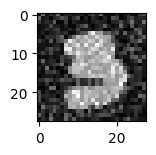

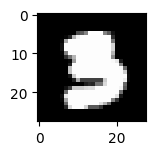

In [39]:
pyplot.subplot(330 + 1)
pyplot.imshow(challenging_images[0], cmap=pyplot.get_cmap('gray'))
pyplot.show()

pyplot.subplot(330 + 1)
pyplot.imshow(x_test[random_indexes[0]], cmap=pyplot.get_cmap('gray'))
pyplot.show()